In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile
from utils.utils import MyDataSet, get_idx_sets
from demo_settings import simu_settings
from CQR import get_CQR_CIs
from models.ddpm import ContextNet, ddpm_schedules, DDPM
from ddpm.train_ddpm import TrainDDPM

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
plt.style.use(FIG_ROOT/"base.mplstyle")

In [5]:
ss.t.rvs(3, size=10)

array([-0.5890561 ,  0.16985603, -0.39502954, -0.20099159,  1.32611852,
        0.94192799, -2.06864292,  0.48013132,  1.22460309,  0.96846807])

In [56]:
# generate data based on (Lei, 2021, JRSSB)
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict

def Xfun(n, d, rho):
    """
    Generate a random matrix X based on the specified parameters.

    Parameters:
    - n (int): Number of rows in the matrix.
    - d (int): Number of columns in the matrix.
    - rho (float): Correlation coefficient.

    Returns:
    - X (ndarray): Random matrix of shape (n, d) based on the specified parameters.
    """

    if rho > 0:
        X = ss.norm.rvs(size=(n, d))
        fac = ss.norm.rvs(size=(n, 1))
        X = X * np.sqrt(1-rho) + fac * np.sqrt(rho)
        X = ss.norm.cdf(X)
    elif rho == 0:
        X = ss.uniform.rvs(size=(n, d))
        #X = ss.norm.rvs(size=(n, d))
    
    return X
def taufun(X):
    """
    Calculate the tauv value based on the given input X.

    Parameters:
    X (numpy.ndarray): Input array of shape (n, 2), where n is the number of samples.

    Returns:
    numpy.ndarray: Array of tauv values calculated based on the input X.
    """
    _f = lambda x: 2/(1+np.exp(-12*(x-0.5)));
    _f2 = lambda x: 4*x**2 + 1
    _f3 = lambda x: np.exp(x**3 - 1)
    tauv = _f(X[:, 0]) * _f2(X[:, 1]) + _f3(X[:, 2]);
    #tauv = _f(X[:, 0]) * _f(X[:, 1]);
    return tauv
def psfun(X):
    """
    Calculate the probability density function of a beta distribution.

    Parameters:
    X (numpy.ndarray): Input array of shape (n, m).

    Returns:
    numpy.ndarray: Array of shape (n,) containing the probability density values.
    """
    return (1+ss.beta.cdf(X[:, 0], a=2, b=4))/4

def sdfun(X, is_homo=True):
    """
    Calculate the similarity scores for the given input data.

    Parameters:
    X (numpy.ndarray): Input data.
    is_homo (bool, optional): Flag indicating whether the data is homogeneous. Defaults to True.

    Returns:
    numpy.ndarray: Similarity scores.
    """
    if is_homo:
        sds = np.ones(X.shape[0])*1
    else:
        sds = -np.log(X[:, 0]+1e-9)
    return sds

def errdist(n):
    #return ss.norm.rvs(size=n)
    rvs = ss.t.rvs(3, size=n)
    return rvs/rvs.std()

def get_simu_data(n, d, rho=0, is_homo=True, is_condition=False):
    """
    Generate simulated data for a causal inference problem.

    Parameters:
    n (int): Number of samples.
    d (int): Number of features.
    rho (float, optional): Correlation coefficient between features. Defaults to 0.
    is_homo (bool, optional): Flag indicating whether the standard deviation of the error term is homogeneous across samples. Defaults to True.
    is_condition (bool, optional): Flag indicating whether the data should be conditioned on a fixed value of X. Defaults to False.

    Returns:
    dataset (edict): A dictionary containing the generated data.
        - X (ndarray): The feature matrix of shape (n, d).
        - ps (ndarray): The propensity scores of shape (n,).
        - Y (ndarray): The outcome variable of shape (n,).
        - Y1 (ndarray): The potential outcome under treatment of shape (n,).
        - T (ndarray): The treatment assignment indicator of shape (n,).
    """
    if is_condition:
        X = np.ones((n, 1)) * Xfun(1, d, rho)
    else:
        X = Xfun(n, d, rho)
    tau = taufun(X)
    std = sdfun(X, is_homo)
    ps = psfun(X)
    
    Y0 = np.zeros(n)
    Y1 = tau + std*errdist(n)
    T = ss.uniform.rvs(size=n) < ps;
    Y = Y0.copy()
    Y[T] = Y1[T]
    
    dataset = edict()
    dataset.X = X
    dataset.ps = ps
    dataset.Y = Y
    dataset.Y1 = Y1
    dataset.T = T
    dataset.tau = tau
    return dataset

# Params

In [57]:
setting = "setting1"

'setting1'

In [71]:
params = edict()

params.simu_setting = edict()
params.simu_setting.rho = 0.9
params.simu_setting.is_homo = False
params.simu_setting.n = 1000
params.simu_setting.d = 10
params.simu_setting.ntest = 1000
params.simu_setting.cal_ratio = 0.25 # for conformal inference
params.simu_setting.val_ratio = 0.15 # for tuning network
params.simu_setting.update(simu_settings[setting])
params.simu_setting.n = 3000
#params.simu_setting.d = 1000
pprint(params.simu_setting)


params.nrep = 50 # num of reptition for simulation
params.K = 20 # num of sps drawn from q(Y(1)|X)
params.save_snapshot = 100
params.dftype = torch.float32
params.device="cpu"
params.n_jobs = 20
params.verbose = True
params.inf_bs = 40 # the inference batch, fct x K

params.ddpm_training = edict()
# Batch size during training
params.ddpm_training.batch_size = 256 
# Number of training epochs
params.ddpm_training.n_epoch = 3000
params.ddpm_training.n_infeat = 128
# Learning rate for optimizers
params.ddpm_training.lr = 0.002
params.ddpm_training.lr_gamma = 0.8
params.ddpm_training.lr_step = 200
params.ddpm_training.test_intv = 5
params.ddpm_training.n_T = 400 # 100
params.ddpm_training.drop_prob = 0.0
params.ddpm_training.n_upblk = 3
params.ddpm_training.n_downblk = 3
params.ddpm_training.weight_decay = 1e-2
#params.ddpm_training.betas = [0.001, 0.5]

params.wconformal = edict()
# remove too large and too small in ws/mean(ws)
params.wconformal.nwthigh = 20
params.wconformal.nwtlow = 0.05
params.wconformal.useinf = False


params.hypo_test = edict()
params.hypo_test.alpha = 0.05 # sig level

params.prefix = ""
params.save_dir = f"demo_ddpm_{setting}_setting_find"
if not (RES_ROOT/params.save_dir).exists():
    (RES_ROOT/params.save_dir).mkdir()

{'cal_ratio': 0.25,
 'd': 10,
 'is_homo': True,
 'n': 3000,
 'ntest': 1000,
 'rho': 0,
 'val_ratio': 0.15}


In [72]:
keys = ["lr", "n_infeat", "n_T", "weight_decay", "n_upblk", "n_downblk"]
def _get_name_postfix(keys):
    return "_".join([f"{key}-{str(params.ddpm_training[key]).split('.')[-1]}" for key in keys])


# Some fns

In [73]:
def _gen_Y_given_X(X, ddpm, seed=1):
    c_all = torch.tensor(X, dtype=params.dftype).to(params.device);
    num_iters = int(np.ceil(c_all.shape[0]/params.inf_bs));
    x_0s = []
    if params.verbose:
        pbar = tqdm(range(num_iters), total=num_iters)
    else:
        pbar = range(num_iters)
    def _run_fn(ix):
        torch.set_default_dtype(params.dftype)
        torch.set_default_device(params.device)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        c_cur = c_all[(ix*params.inf_bs):(ix*params.inf_bs+params.inf_bs)]
        c_cur_mul = c_cur.repeat(params.K, 1);
        with torch.no_grad():
            x_0, _ = ddpm.sample(c_cur_mul, device=params.device, guide_w=0, is_store=False);
        x_0 = x_0.cpu().numpy().reshape(-1);
        x_0 = x_0.reshape(params.K, -1);
        return x_0
    with Parallel(n_jobs=params.n_jobs) as parallel:
        x_0s = parallel(delayed(_run_fn)(ix) for ix in pbar)
    x_0s = np.concatenate(x_0s, axis=1).T;
    return x_0s
def _get_pred_intv(teY_hat, qv):
    intvs = np.stack([teY_hat-qv, teY_hat+qv]).T
    return merge_intervals(intvs)
def _get_metric(v, intvs):
    if not isinstance(v, np.ndarray):
        v = np.array(v)
    in_sets = np.sum([np.bitwise_and(v>intv[0], v<intv[1]) for intv in intvs], axis=0)
    intvs_len = np.sum([np.diff(intv) for intv in intvs])
    metrics = edict()
    metrics.in_sets = in_sets
    metrics.intvs_len = intvs_len
    return metrics

In [74]:
def _run_fn_PCP(rep_ix):
    manualSeed = rep_ix
    random.seed(manualSeed)
    np.random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.use_deterministic_algorithms(True) # Needed for reproducible results
    torch.set_default_dtype(params.dftype)
    torch.set_default_device(params.device)
    
    #beta = np.concatenate([np.random.randn(2), np.zeros(params.simu_setting.d-2)])
    #inp = np.random.randn(1) * 10                                
    
    data_train = get_simu_data(n=params.simu_setting.n, 
                               d=params.simu_setting.d, 
                               #beta=beta, 
                               #inp=inp,
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);
    data_test = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               #beta=beta, 
                               #inp=inp,
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);
    
    cal_idxs, val_idxs, tr_idxs = get_idx_sets(all_idxs=np.where(data_train.T)[0], 
                                               ratios = [params.simu_setting.cal_ratio, params.simu_setting.val_ratio])
        
        
    # train q(Y(1)|X)
    # I skip this for now, suppose you get one
    data_train_ddpm = MyDataSet(Y=data_train.Y[tr_idxs], X=data_train.X[tr_idxs])
    data_val = edict()
    data_val.c =  data_train.X[val_idxs]
    data_val.x =  data_train.Y[val_idxs]
    
    input_params = params.ddpm_training.copy()
    input_params.pop("n_epoch")
    myddpm = TrainDDPM(data_train_ddpm, save_dir=params.save_dir, verbose=params.verbose, prefix=f"rep{rep_ix}", 
                       device=params.device,
                       **input_params);
    myddpm.train(n_epoch=params.ddpm_training.n_epoch, 
                 data_val=data_val, save_snapshot=params.save_snapshot)
    #ddpm = myddpm.ddpm
    ddpm = myddpm.get_opt_model()
    #ddpm = myddpm.get_model(500)
    ddpm.eval()
    
    def wtfun(x):
        if x.ndim == 1:
            x = x.reshape(1, -1)
        # for unconditional weight
        return np.ones(x.shape[0])
        
    # get the weight and nonconformity score for each data point in cal set
    x_0s = _gen_Y_given_X(data_train.X[cal_idxs], ddpm, manualSeed)
    ws = wtfun(data_train.X[cal_idxs]);
    Es = np.abs(x_0s -  data_train.Y1[cal_idxs][:, None]).min(axis=1);
            
    def _run_fn2(te_idx):
        torch.set_default_dtype(params.dftype)
        teX = data_test.X[te_idx]
        teY1 = data_test.Y1[te_idx]
        tetau = data_test.tau[te_idx]
        
        # get qv for current test pt
        ws_wtest = np.concatenate([ws, wtfun(teX)]);
        Es_winf = np.concatenate([Es, [np.inf]]);
        nws_wtest = ws_wtest/ws_wtest.mean();
        nws_wtest[nws_wtest<params.wconformal.nwtlow] = params.wconformal.nwtlow
        nws_wtest[nws_wtest>params.wconformal.nwthigh] = params.wconformal.nwthigh
        # can not take the inf into consider
        #qv_cur = weighted_quantile(Es_winf, [1-params.hypo_test.alpha], sample_weight=nws_wtest);
        qt = (1 + nws_wtest[-1]/ nws_wtest[:-1].sum()) * (1 - params.hypo_test.alpha)
        if qt <= 1:
            qv_cur = weighted_quantile(Es, [qt], sample_weight=ws_wtest[:-1])[0];
        else:
            if params.wconformal.useinf:
                qv_cur = np.inf
            else:
                qv_cur = np.max(Es)
        
        intvs = _get_pred_intv(teYs_hat[te_idx], qv_cur)
        res = _get_metric([teY1, tetau], intvs)
        res["qv_cur"] = qv_cur
        res["qt"] = qt
        res["intvs"] = intvs
        return res
        
    teYs_hat = _gen_Y_given_X(data_test.X, ddpm, manualSeed);
    pbar2 = range(params.simu_setting.ntest)
    with Parallel(n_jobs=1) as parallel:
        test_res = parallel(delayed(_run_fn2)(te_idx) for te_idx in pbar2)
        
    prbs = np.mean([res['in_sets'] for res in test_res], axis=0)
    mlen = np.median([res['intvs_len'] for res in test_res])
        
        
    # results from CQR
    CQR_CIs = get_CQR_CIs(X=data_train.X, Y=data_train.Y, 
                          T=data_train.T, Xtest=data_test.X, 
                          nav=0, 
                          alpha=params.hypo_test.alpha, 
                          estimand="nonmissing",
                          fyx_est="quantBoosting", seed=manualSeed)
    mlen_cqr = np.median(CQR_CIs[:, 1] -  CQR_CIs[:, 0])
    prb_Y1_cqr = np.bitwise_and(data_test.Y1>CQR_CIs[:, 0], data_test.Y1<CQR_CIs[:, 1]).mean()
    prb_tau_cqr = np.bitwise_and(data_test.tau>CQR_CIs[:, 0], data_test.tau<CQR_CIs[:, 1]).mean()
    
    res_all = edict()
    res_all.DDPM = (prbs, mlen)
    res_all.CQR = ([prb_Y1_cqr, prb_tau_cqr], mlen_cqr)
    return res_all, myddpm, test_res, np.abs(x_0s -  data_train.Y1[cal_idxs][:, None])

In [78]:
res = _run_fn_PCP(100);

2023-12-20 00:12:09,971 - ddpm.train_ddpm - INFO - The results are saved at /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_setting1_setting_find.
INFO:ddpm.train_ddpm:The results are saved at /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_setting1_setting_find.
2023-12-20 00:12:09,993 - ddpm.train_ddpm - INFO - The params is {'lr': 0.002, 'batch_size': 256, 'device': 'cpu', 'n_T': 400, 'n_infeat': 128, 'n_upblk': 3, 'n_downblk': 3, 'betas': [0.0001, 0.02], 'drop_prob': 0.0, 'lr_gamma': 0.8, 'lr_step': 200, 'test_intv': 5, 'weight_decay': 0.01}
INFO:ddpm.train_ddpm:The params is {'lr': 0.002, 'batch_size': 256, 'device': 'cpu', 'n_T': 400, 'n_infeat': 128, 'n_upblk': 3, 'n_downblk': 3, 'betas': [0.0001, 0.02], 'drop_prob': 0.0, 'lr_gamma': 0.8, 'lr_step': 200, 'test_intv': 5, 'weight_decay': 0.01}


The num of params is 0.83m. 
Adjusting learning rate of group 0 to 2.0000e-03.


loss: 0.5170:   3%|█▍                                          | 99/3000 [00:06<03:08, 15.43it/s, val loss=0.509]2023-12-20 00:12:16,582 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch100.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch100.pth.
loss: 0.4637:   7%|██▉                                         | 199/3000 [00:13<03:31, 13.26it/s, val loss=0.42]2023-12-20 00:12:23,198 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch200.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch200.pth.
loss: 0.4042:   7%|██▉                                         | 201/3000 [00:13<04:03, 11.48it/s, val loss=0.42]

Adjusting learning rate of group 0 to 1.6000e-03.


loss: 0.3774:  10%|████▍                                       | 299/3000 [00:20<03:25, 13.13it/s, val loss=0.38]2023-12-20 00:12:30,124 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch300.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch300.pth.
loss: 0.4421:  13%|█████▋                                     | 399/3000 [00:27<03:00, 14.42it/s, val loss=0.479]2023-12-20 00:12:37,779 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch400.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch400.pth.
loss: 0.4424:  13%|█████▋                                     | 399/3000 [00:27<03:00, 14.42it/s, val loss=0.479]

Adjusting learning rate of group 0 to 1.2800e-03.


loss: 0.4410:  17%|███████▏                                   | 499/3000 [00:34<02:22, 17.52it/s, val loss=0.393]2023-12-20 00:12:44,536 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch500.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch500.pth.
loss: 0.3868:  20%|████████▌                                  | 599/3000 [00:41<02:55, 13.64it/s, val loss=0.485]2023-12-20 00:12:51,079 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch600.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch600.pth.
loss: 0.3994:  20%|████████▌                                  | 601/3000 [00:41<03:23, 11.80it/s, val loss=0.485]

Adjusting learning rate of group 0 to 1.0240e-03.


loss: 0.3847:  23%|██████████                                 | 699/3000 [00:47<02:21, 16.31it/s, val loss=0.376]2023-12-20 00:12:57,363 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch700.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch700.pth.
loss: 0.3771:  27%|███████████▍                               | 799/3000 [00:53<02:18, 15.89it/s, val loss=0.359]2023-12-20 00:13:03,710 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch800.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch800.pth.
loss: 0.4279:  27%|███████████▍                               | 801/3000 [00:53<02:46, 13.24it/s, val loss=0.359]

Adjusting learning rate of group 0 to 8.1920e-04.


loss: 0.3469:  30%|████████████▉                              | 899/3000 [01:00<02:07, 16.49it/s, val loss=0.445]2023-12-20 00:13:10,744 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch900.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch900.pth.
loss: 0.4069:  33%|██████████████▎                            | 999/3000 [01:06<02:01, 16.49it/s, val loss=0.343]2023-12-20 00:13:16,953 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch1000.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch1000.pth.
loss: 0.3278:  33%|██████████████                            | 1001/3000 [01:07<02:27, 13.55it/s, val loss=0.343]

Adjusting learning rate of group 0 to 6.5536e-04.


loss: 0.3057:  37%|███████████████▊                           | 1099/3000 [01:13<02:21, 13.42it/s, val loss=0.33]2023-12-20 00:13:23,469 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch1100.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch1100.pth.
loss: 0.3158:  40%|████████████████▊                         | 1199/3000 [01:20<01:49, 16.47it/s, val loss=0.373]2023-12-20 00:13:30,420 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch1200.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch1200.pth.
loss: 0.3400:  40%|████████████████▊                         | 1201/3000 [01:20<02:18, 12.99it/s, val loss=0.373]

Adjusting learning rate of group 0 to 5.2429e-04.


loss: 0.3219:  43%|██████████████████▏                       | 1299/3000 [01:26<02:05, 13.55it/s, val loss=0.449]2023-12-20 00:13:36,911 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch1300.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch1300.pth.
loss: 0.3446:  47%|███████████████████▌                      | 1399/3000 [01:33<01:31, 17.54it/s, val loss=0.521]2023-12-20 00:13:43,933 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch1400.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch1400.pth.
loss: 0.2997:  47%|███████████████████▌                      | 1401/3000 [01:34<01:52, 14.22it/s, val loss=0.521]

Adjusting learning rate of group 0 to 4.1943e-04.


loss: 0.3281:  50%|████████████████████▉                     | 1499/3000 [01:40<01:25, 17.54it/s, val loss=0.464]2023-12-20 00:13:50,048 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch1500.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch1500.pth.
loss: 0.2794:  53%|███████████████████████▍                    | 1599/3000 [01:46<01:46, 13.17it/s, val loss=0.4]2023-12-20 00:13:56,961 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch1600.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch1600.pth.
loss: 0.3327:  53%|███████████████████████▍                    | 1601/3000 [01:47<02:00, 11.62it/s, val loss=0.4]

Adjusting learning rate of group 0 to 3.3554e-04.


loss: 0.3011:  57%|███████████████████████▊                  | 1699/3000 [01:53<01:16, 16.97it/s, val loss=0.549]2023-12-20 00:14:03,349 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch1700.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch1700.pth.
loss: 0.3349:  60%|█████████████████████████▊                 | 1799/3000 [01:59<01:16, 15.61it/s, val loss=0.53]2023-12-20 00:14:09,560 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch1800.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch1800.pth.
loss: 0.3025:  60%|█████████████████████████▊                 | 1801/3000 [01:59<01:34, 12.70it/s, val loss=0.53]

Adjusting learning rate of group 0 to 2.6844e-04.


loss: 0.3156:  63%|███████████████████████████▏               | 1899/3000 [02:06<01:10, 15.72it/s, val loss=0.47]2023-12-20 00:14:16,028 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch1900.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch1900.pth.
loss: 0.2641:  67%|███████████████████████████▉              | 1999/3000 [02:12<01:02, 15.95it/s, val loss=0.573]2023-12-20 00:14:22,728 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch2000.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch2000.pth.
loss: 0.2203:  67%|████████████████████████████              | 2001/3000 [02:12<01:13, 13.56it/s, val loss=0.573]

Adjusting learning rate of group 0 to 2.1475e-04.


loss: 0.2418:  70%|█████████████████████████████▍            | 2099/3000 [02:19<00:56, 15.89it/s, val loss=0.638]2023-12-20 00:14:29,596 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch2100.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch2100.pth.
loss: 0.2334:  73%|███████████████████████████████▌           | 2199/3000 [02:27<01:01, 13.10it/s, val loss=0.53]2023-12-20 00:14:37,253 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch2200.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch2200.pth.
loss: 0.2135:  73%|███████████████████████████████▌           | 2201/3000 [02:27<01:09, 11.56it/s, val loss=0.53]

Adjusting learning rate of group 0 to 1.7180e-04.


loss: 0.2662:  77%|████████████████████████████████▏         | 2299/3000 [02:34<00:42, 16.65it/s, val loss=0.712]2023-12-20 00:14:44,033 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch2300.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch2300.pth.
loss: 0.2483:  80%|█████████████████████████████████▌        | 2399/3000 [02:40<00:41, 14.39it/s, val loss=0.694]2023-12-20 00:14:50,457 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch2400.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch2400.pth.
loss: 0.2650:  80%|█████████████████████████████████▌        | 2401/3000 [02:40<00:48, 12.38it/s, val loss=0.694]

Adjusting learning rate of group 0 to 1.3744e-04.


loss: 0.2631:  83%|██████████████████████████████████▉       | 2499/3000 [02:47<00:38, 13.07it/s, val loss=0.551]2023-12-20 00:14:57,600 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch2500.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch2500.pth.
loss: 0.2773:  87%|████████████████████████████████████▍     | 2599/3000 [02:54<00:26, 15.39it/s, val loss=0.522]2023-12-20 00:15:04,600 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch2600.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch2600.pth.
loss: 0.2470:  87%|████████████████████████████████████▍     | 2599/3000 [02:54<00:26, 15.39it/s, val loss=0.522]

Adjusting learning rate of group 0 to 1.0995e-04.


loss: 0.2163:  90%|█████████████████████████████████████▊    | 2699/3000 [03:01<00:17, 17.52it/s, val loss=0.503]2023-12-20 00:15:11,718 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch2700.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch2700.pth.
loss: 0.2326:  93%|███████████████████████████████████████▏  | 2799/3000 [03:08<00:12, 16.58it/s, val loss=0.519]2023-12-20 00:15:18,032 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch2800.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch2800.pth.
loss: 0.2896:  93%|███████████████████████████████████████▏  | 2801/3000 [03:08<00:14, 14.03it/s, val loss=0.519]

Adjusting learning rate of group 0 to 8.7961e-05.


loss: 0.2234:  97%|████████████████████████████████████████▌ | 2899/3000 [03:14<00:06, 15.25it/s, val loss=0.621]2023-12-20 00:15:24,779 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch2900.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch2900.pth.
loss: 0.1955: 100%|█████████████████████████████████████████▉| 2999/3000 [03:21<00:00, 16.80it/s, val loss=0.722]2023-12-20 00:15:31,237 - ddpm.train_ddpm - INFO - Save model rep100_ddpm_epoch3000.pth.
INFO:ddpm.train_ddpm:Save model rep100_ddpm_epoch3000.pth.
loss: 0.1955: 100%|██████████████████████████████████████████| 3000/3000 [03:21<00:00, 14.90it/s, val loss=0.722]
2023-12-20 00:15:31,308 - ddpm.train_ddpm - INFO - We load model /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_setting1_setting_find/rep100_ddpm_epoch1900.pth with val loss 0.486.
INFO:ddpm.train_ddpm:We load model /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_setting1_

Adjusting learning rate of group 0 to 7.0369e-05.


100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 785.86it/s]


In [79]:
print(res[0])
myddpm = res[1]

{'DDPM': [array([0.946, 0.996]), 4.8949237], 'CQR': [[0.928, 1.0], 5.295771345290358]}


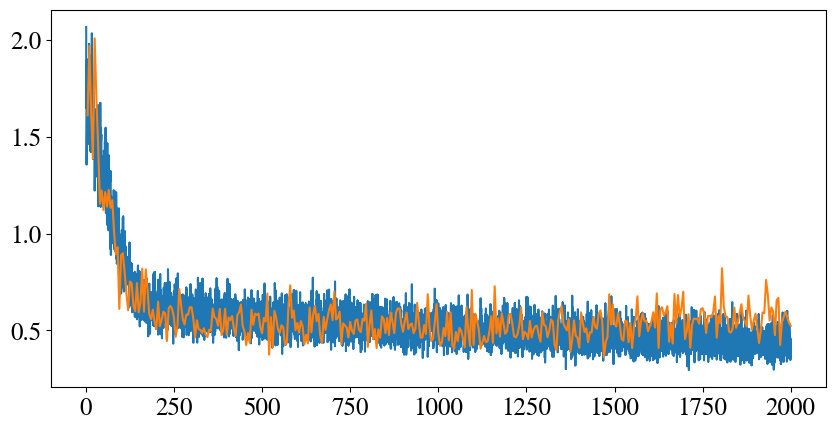

In [23]:
eps = np.array(myddpm.losses)[:, 0]
loss = np.array(myddpm.losses)[:, 1]
eps_val = np.array(myddpm.losses_val)[:, 0]
loss_val = np.array(myddpm.losses_val)[:, 1];
plt.plot(eps, loss)
plt.plot(eps_val, loss_val)

# evaluate

In [27]:
ddpm = myddpm.ddpm;

## ON test set

In [28]:
data_test = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               #beta=beta, 
                               #inp=inp,
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho);

In [29]:
tX = torch.tensor(data_test.X);
c = tX.type(params.dftype);

In [30]:
ddpm.eval()
with torch.no_grad():
    x_i, x_is = ddpm.sample(c, device="cpu", guide_w=2, is_store=False);

(-10.0, 10.0)

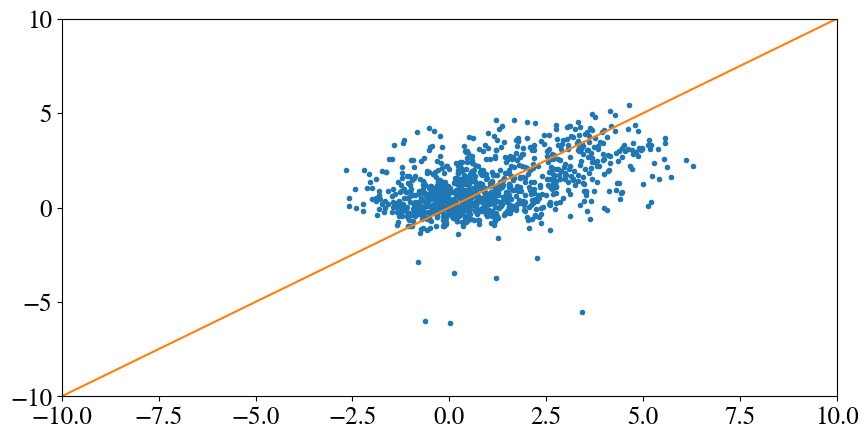

In [31]:
predx0 = x_i.reshape(-1).numpy();
x0 = data_test.Y1;
plt.plot(x0, predx0, ".")
xx = np.linspace(-10, 10, 100)
yy = xx
plt.plot(xx, yy)
plt.xlim([-10, 10])
plt.ylim([-10, 10])

## Given X

In [41]:
datatest_con = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho, 
                               is_condition=True);
tX_con = torch.tensor(datatest_con.X);
c = tX_con.type(params.dftype);

In [42]:
ddpm.eval()
with torch.no_grad():
    x_i, x_is = ddpm.sample(c, device="cpu", guide_w=0);

(-5.0, 10.0)

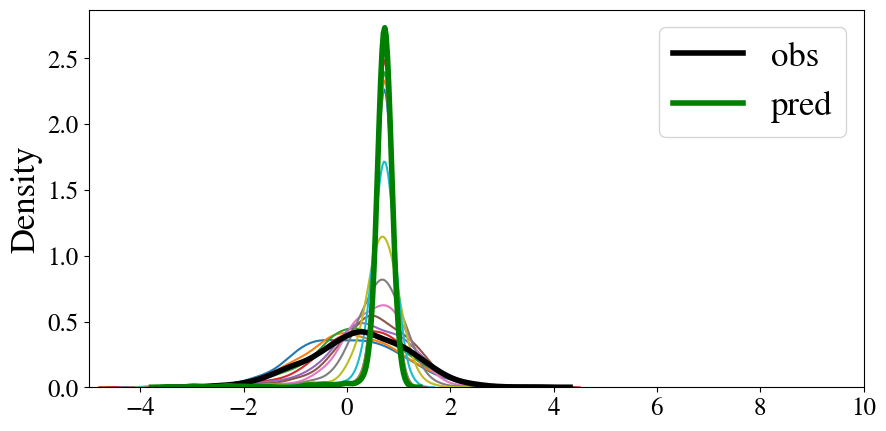

In [43]:
predx0 = x_i.reshape(-1).numpy();
x0 = datatest_con.Y1;
x_is = x_is.squeeze();
for idx in range(x_is.shape[0]):
    sns.kdeplot(x_is[idx])
sns.kdeplot(x0, color="black", lw=4, label="obs")
sns.kdeplot(predx0, color="green", lw=4, label="pred")
plt.legend()
plt.xlim([-5, 10])

# bak